# Tutorial 02 - Scikit-learn  

### GPU SUPPORT

In [ ]:
!pip install scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 MB 6.4 MB/s eta 0:00:00


### IMPORTS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.utils import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack

# gpu-support
# from sklearnex import patch_sklearn
# patch_sklearn()

### BASELINE

precision-macro=83.90%

recall-macro=84.75%

f1-macro=84.27%

---

### Logistic Regression

precision-macro=92.83%

recall-macro=92.88%

f1-macro=92.85%

---

### SVM
precision-macro=94.28%

recall-macro=94.38%

f1-macro=94.33%

---

### Bayesian

precision-macro=91.90%

recall-macro=89.00%

f1-macro=90.21%

---

### Random Forest

precision-macro=92.49%

recall-macro=84.61%

f1-macro=86.91%

---

### Perceptron

precision-macro=34.46%

recall-macro=27.40%

f1-macro=30.53%

---

### Bigram approach

precision-macro=91.13%

recall-macro=76.61%

f1-macro=83.24%
****


In [ ]:
!ls

sample_data


### LOAD DATASET

In [ ]:
X, Y = [], []
words = []
with open('a4-data.txt', 'rt', encoding='utf8') as fr:
    lines = fr.read().split('\n')
    for line in lines:
        w, label = line.split('\t')
        X.append(w), Y.append(int(label))
        words.append(w)
X, Y = np.array(X), np.array(Y)
print(f'total examples: {len(X), X.shape, len(Y), Y.shape}')
print('-' * 50)

total examples: (10336, (10336,), 10336, (10336,))
--------------------------------------------------


### SPLIT DATASET INTO TRAIN/DEV/TEST

In [ ]:
# split first into train, test
train_examples, test_examples, train_labels, test_labels = train_test_split(X, Y, train_size=.8, test_size=.2,
                                                                            random_state=1, shuffle=True)

# split the train further into dev
train_examples, dev_examples, train_labels, dev_labels = train_test_split(train_examples, train_labels, train_size=.9,
                                                                          test_size=.1, random_state=1, shuffle=True)

print(f'train examples: {len(train_examples), len(train_labels)}\n'
      f'dev examples: {len(dev_examples), len(dev_labels)}\n'
      f'test examples: {len(test_examples), len(test_labels)}')



train examples: (7441, 7441)
dev examples: (827, 827)
test examples: (2068, 2068)


### Extract Features

In [ ]:
def to_features(examples):
    return np.array([len(w) for w in examples]).reshape(-1, 1)


vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))

train_vectors = vectorizer.fit_transform(train_examples, train_labels)
train_vectors = hstack([train_vectors, to_features(train_examples)])

dev_vectors = vectorizer.transform(dev_examples)
dev_vectors = hstack([dev_vectors, to_features(dev_examples)])

test_vectors = vectorizer.transform(test_examples)
test_vectors = hstack([test_vectors, to_features(test_examples)])

print(train_vectors.shape, dev_vectors.shape, test_vectors.shape)

(7441, 6591) (827, 6591) (2068, 6591)


### More Features

In [ ]:
X_feats = np.array([
    [
        len(w), # word length
        sum([1 for c in w if c in 'aeiouyäöü']), # number of vowels
        int('-' in w), # contains hyphens? (1 or 0)
        # [more features can be defined here]
    ]
    for w in words
])

y = Y

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

class WordLengthTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return np.array([[len(w)] for w in X]).astype(int)

class VowelRatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        features = []
        for word in X:
            vowels = sum(1 for ch in word.lower() if ch in 'aeiouäöü')
            consonants = sum(1 for ch in word.lower() if ch.isalpha() and ch not in 'aeiouäöü')
            ratio = vowels / consonants if consonants > 0 else 0
            features.append([ratio])
        return np.array(features)

class WordEndingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.vec = DictVectorizer()
        endings = [{'suffix': word[-3:] if len(word) >= 3 else word} for word in X]
        self.vec.fit(endings)
        return self

    def transform(self, X):
        suffixes = [{'suffix': word[-3:] if len(word) >= 3 else word} for word in X]
        return self.vec.transform(suffixes)

class HyphenFeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([[1 if '-' in word else 0] for word in X]).astype(int)

### INSPECT CLASS DISTRIBUTION (FOR EXAMPLE)
#### I want to see whether the dataset is balanced

In [ ]:
labels = np.array(sorted(set(train_labels).union(dev_labels).union(test_labels)))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}
print(labels)

train_labels_freq = Counter(train_labels)
dev_labels_freq = Counter(dev_labels)
test_labels_freq = Counter(test_labels)

print(train_labels_freq)

zero_labels = train_labels_freq[0] + dev_labels_freq[0] + test_labels_freq[0]
one_labels = train_labels_freq[1] + dev_labels_freq[1] + test_labels_freq[1]

# class zero is twice more often class
print(zero_labels, one_labels)

print(compute_class_weight(class_weight="balanced", classes=labels, y=Y))

[0 1]
Counter({np.int64(0): 4797, np.int64(1): 2644})
6682 3654
[0.77342113 1.41434045]


### Example Workflow
1. Find the best model to predict the dev data with K-Fold GridSearch
2. Use it on the test data
3. Evaluate the results

### Logistic Regression

### Grid Search

In [ ]:
grid = GridSearchCV(LogisticRegression(random_state=1, penalty='l2'), param_grid=
{'C': [0.01, 0.05, 0.1, 0.5, 1], 'max_iter': [30, 50, 100, 200], 'class_weight': ['balanced']}, cv=5,
                    scoring='f1_macro')

grid.fit(train_vectors, train_labels)

# you can also directly use best estimator on training data
# best_train_lr = grid.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1],
                         'class_weight': ['balanced'],
                         'max_iter': [30, 50, 100, 200]},
             scoring='f1_macro')

### Best Model on Dev (redundant, already done in the GridSearch)

In [ ]:
# usually we want the best estimator on the dev set to make sure our model generalizes enough

best_lr, best_pr, best_r, bestf1 = None, 0.0, 0.0, 0.0
for param in grid.cv_results_['params']:
    model = LogisticRegression(**param, random_state=1, penalty='l2')
    model.fit(train_vectors, train_labels)
    y_dev_preds = model.predict(dev_vectors)

    # in this case, I choose the model with best f1-macro average
    f1 = f1_score(dev_labels, y_dev_preds, average='macro')
    if f1 > bestf1:
        bestf1 = f1
        best_pr = precision_score(dev_labels, y_dev_preds, average='macro')
        best_r = recall_score(dev_labels, y_dev_preds, average='macro')
        best_lr = model

# with best model on the dev set
print(best_lr)
print(f'precision-macro: {round(best_pr, 4) * 100}%\n'
      f'recall-macro: {round(best_r, 4) * 100}%\n'
      f'f1-macro: {round(bestf1, 4) * 100}%')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression(C=1, class_weight='balanced', max_iter=50, random_state=1)
precision-macro: 91.83%
recall-macro: 92.67999999999999%
f1-macro: 92.23%


### Evaluate on test set

In [ ]:
# use best model on the test set
y_pred = best_lr.predict(test_vectors)

pmacro, rmacro, f1macro = precision_score(test_labels, y_pred, average='macro'), recall_score(test_labels, y_pred,
                                                                                              average='macro'), f1_score(
    test_labels, y_pred, average='macro')

pmicro, rmicro, f1micro = precision_score(test_labels, y_pred, average='micro'), recall_score(test_labels, y_pred,
                                                                                              average='micro'), f1_score(
    test_labels, y_pred, average='micro')

print(
    f'precision-micro: {round(pmicro, 4) * 100}% recall-micro: {round(rmicro, 4) * 100}% f1-micro: {round(f1micro, 4) * 100}%')
print('-' * 50)
print(
    f'precision-macro: {round(pmacro, 4) * 100}% recall-macro: {round(rmacro, 4) * 100}% f1-macro: {round(f1macro, 4) * 100}%')

precision-micro: 93.42% recall-micro: 93.42% f1-micro: 93.42%
--------------------------------------------------
precision-macro: 92.83% recall-macro: 92.88% f1-macro: 92.85%


### SVM

In [ ]:
grid = GridSearchCV(SVC(random_state=1, kernel='linear'), param_grid={
    'C': [0.01, 0.1, 1],
    'class_weight': ['balanced'],
    'max_iter': [1000, 2000, 3000, 5000]
}, cv=5, scoring='f1_macro')

# gives the best estimator on the train data
grid.fit(train_vectors, train_labels)
best_train_svm = grid.best_estimator_

# with best model on train data
print(best_train_svm, f1_score(dev_labels, best_train_svm.predict(dev_vectors), average='macro'))


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

SVC(C=1, class_weight='balanced', kernel='linear', max_iter=3000,
    random_state=1) 0.9290466070933594


In [ ]:
best_svm, best_pr, best_r, bestf1 = None, 0.0, 0.0, 0.0

for param in grid.cv_results_['params']:
    model = SVC(**param, random_state=1, kernel='linear')
    model.fit(train_vectors, train_labels)
    y_dev_preds = model.predict(dev_vectors)
    f1 = f1_score(dev_labels, y_dev_preds, average='macro')
    if f1 > bestf1:
        bestf1 = f1
        best_pr = precision_score(dev_labels, y_dev_preds, average='macro')
        best_r = recall_score(dev_labels, y_dev_preds, average='macro')
        best_svm= model


# with best model on the dev set
print(best_svm, bestf1)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

SVC(C=1, class_weight='balanced', kernel='linear', max_iter=5000,
    random_state=1) 0.9303468537427604


In [ ]:
# use best model on the test set
y_pred = best_svm.predict(test_vectors)

pmacro, rmacro, f1macro = precision_score(test_labels, y_pred, average='macro'), recall_score(test_labels, y_pred,
                                                                                              average='macro'), f1_score(
    test_labels, y_pred, average='macro')

pmicro, rmicro, f1micro = precision_score(test_labels, y_pred, average='micro'), recall_score(test_labels, y_pred,
                                                                                              average='micro'), f1_score(
    test_labels, y_pred, average='micro')

print(
    f'precision-micro: {round(pmicro, 4) * 100}% recall-micro: {round(rmicro, 4) * 100}% f1-micro: {round(f1micro, 4) * 100}%')
print('-' * 50)
print(
    f'precision-macro: {round(pmacro, 4) * 100}% recall-macro: {round(rmacro, 4) * 100}% f1-macro: {round(f1macro, 4) * 100}%')

precision-micro: 94.78% recall-micro: 94.78% f1-micro: 94.78%
--------------------------------------------------
precision-macro: 94.28% recall-macro: 94.38% f1-macro: 94.33%


### Random Forest

In [ ]:

grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid={
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 3]
}, cv=5, scoring='f1_macro')

# gives the best estimator on the train data
grid.fit(train_vectors, train_labels)
best_train_rf = grid.best_estimator_

# with best model on train data
print(best_train_rf, f1_score(dev_labels, best_train_rf.predict(dev_vectors), average='macro'))


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=1) 0.872488986784141


In [ ]:

best_rf, bestf1, best_pr, best_r = None, 0.0, 0.0, 0.0
for param in grid.cv_results_['params']:
    model = RandomForestClassifier(**param, random_state=1)
    model.fit(train_vectors, train_labels)
    y_dev_preds = model.predict(dev_vectors)
    f1 = f1_score(dev_labels, y_dev_preds, average='macro')
    if f1 > bestf1:
        bestf1 = f1
        best_pr = precision_score(dev_labels, y_dev_preds, average='macro')
        best_r = recall_score(dev_labels, y_dev_preds, average='macro')
        best_rf = model

# with best model on the dev set
print(best_rf, bestf1)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=1) 0.872488986784141


In [ ]:
# use best model on the test set
y_pred = best_rf.predict(test_vectors)

pmacro, rmacro, f1macro = precision_score(test_labels, y_pred, average='macro'), recall_score(test_labels, y_pred,
                                                                                              average='macro'), f1_score(
    test_labels, y_pred, average='macro')

pmicro, rmicro, f1micro = precision_score(test_labels, y_pred, average='micro'), recall_score(test_labels, y_pred,
                                                                                              average='micro'), f1_score(
    test_labels, y_pred, average='micro')

print(
    f'precision-micro: {round(pmicro, 4) * 100}% recall-micro: {round(rmicro, 4) * 100}% f1-micro: {round(f1micro, 4) * 100}%')
print('-' * 50)
print(
    f'precision-macro: {round(pmacro, 4) * 100}% recall-macro: {round(rmacro, 4) * 100}% f1-macro: {round(f1macro, 4) * 100}%')

precision-micro: 88.92999999999999% recall-micro: 88.92999999999999% f1-micro: 88.92999999999999%
--------------------------------------------------
precision-macro: 92.49000000000001% recall-macro: 84.61% f1-macro: 86.91%


### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_feats, y, test_size=0.2, random_state=42)


perceptron = Perceptron(random_state=42) # Set random seed to ensure reproducibility
perceptron.fit(X_train, y_train)

Perceptron(random_state=42)

In [ ]:
y_pred = perceptron.predict(X_test)

print(f"F1 score: {f1_score(test_labels, y_pred)}")
print(f"Accuracy: {accuracy_score(test_labels, y_pred)}")
print(f"Precision: {precision_score(test_labels, y_pred)}")
print(f"Recall: {recall_score(test_labels, y_pred)}")

F1 score: 0.30526315789473685
Accuracy: 0.5531914893617021
Precision: 0.34465195246179964
Recall: 0.2739541160593792


### Bayesian

In [ ]:
combined_features = FeatureUnion([
    ('length>8', WordLengthTransformer()),
    ('vowel_ratio', VowelRatioTransformer()),
    ('suffix', WordEndingTransformer()),
    ('hyphen', HyphenFeatureTransformer())
])

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import BayesianRidge

bayesian_pipeline = Pipeline([
    ('features', combined_features),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),  # Convert to dense
    ('clf', BayesianRidge())
])

bayesian_pipeline.fit(train_examples, np.array(train_labels).astype(float))


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('length>8',
                                                 WordLengthTransformer()),
                                                ('vowel_ratio',
                                                 VowelRatioTransformer()),
                                                ('suffix',
                                                 WordEndingTransformer()),
                                                ('hyphen',
                                                 HyphenFeatureTransformer())])),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x7a9d5d73dc60>)),
                ('clf', BayesianRidge())])

In [ ]:
bayesian_preds = bayesian_pipeline.predict(test_examples)
bayesian_preds = (bayesian_preds >= 0.5).astype(int)  # Threshold for binary classification

In [ ]:
test_labels = np.array([int(x) for x in test_labels])
bayesian_preds = np.array([int(x) for x in bayesian_preds])

In [ ]:
# Evaluation
for name, preds in [('BayesianRidge', bayesian_preds)]:
    print(f'\n{name} Evaluation:')
    print('F1 Macro:', f1_score(test_labels, preds, average='macro'))
    print('Recall Macro:', recall_score(test_labels, preds, average='macro'))
    print('Precision Macro:', precision_score(test_labels, preds, average='macro'))



BayesianRidge Evaluation:
F1 Macro: 0.9154429852155803
Recall Macro: 0.9019670357273974
Precision Macro: 0.936294898116873


### Bigram approach

In [ ]:
all_known_bigrams = set()
for w in words:
  for i in range(len(w) -1):
      all_known_bigrams.add(w[i:i+2])

bigram_vectors = []
for word in words:
  # extract word bigrams
  bigrams = set()
  for i in range(len(word) - 1):
    bigrams.add(word[i:i+2])
  # create bigram vector
  vector = []
  for bigram in all_known_bigrams:
      vector.append(1 if bigram in bigrams else 0)
  bigram_vectors.append(vector)

In [ ]:
# fit perceptron
X_feats = bigram_vectors
X_train, X_test, y_train, y_test = train_test_split(X_feats, y, test_size=0.2, random_state=42)
perceptron = Perceptron(random_state=42) # Set random seed to ensure reproducibility
perceptron.fit(X_train, y_train)

# evaluate
y_pred = perceptron.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

F1 score: 0.8324240062353858
Accuracy: 0.8960348162475822
Precision: 0.9112627986348123
Recall: 0.7661406025824964


### BEST-MODEL

In [ ]:
print(best_svm)

y_pred = best_svm.predict(test_vectors)

print(classification_report(test_labels, y_pred, labels=labels, target_names=['class 0', 'class 1']))

SVC(C=1, class_weight='balanced', kernel='linear', max_iter=5000,
    random_state=1)
              precision    recall  f1-score   support

     class 0       0.96      0.96      0.96      1327
     class 1       0.92      0.93      0.93       741

    accuracy                           0.95      2068
   macro avg       0.94      0.94      0.94      2068
weighted avg       0.95      0.95      0.95      2068



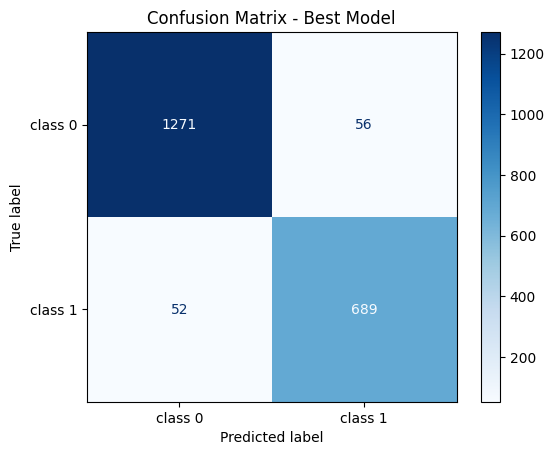

In [ ]:
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(confusion_matrix(test_labels, y_pred), display_labels=['class 0', 'class 1']).plot(
    cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model')
plt.show()